# IREI: Non Textual Information Retrieval - Implementation of a "Toy" CBIR system
### Víctor Morcuende Castell and Guillermo Nájera Lavid
#### Course 2022-2023

In [305]:
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.neighbors import KNeighborsClassifier

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

Labels of the CIFAR10 dataset

In [306]:
LABELS = {0:'airplane', 
          1: 'automobile',
          2: 'bird',
          3: 'cat',
          4: 'deer',
          5: 'dog',
          6: 'frog',
          7: 'horse',
          8: 'ship',
          9: 'truck'
         }

Load dataset and rescale to a [0, 1] range

In [307]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

print(f'Shape train set: {x_train.shape}, Shape test set: {x_test.shape}')

Shape train set: (50000, 32, 32, 3), Shape test set: (10000, 32, 32, 3)


Visualizing the first 10 images of the train set

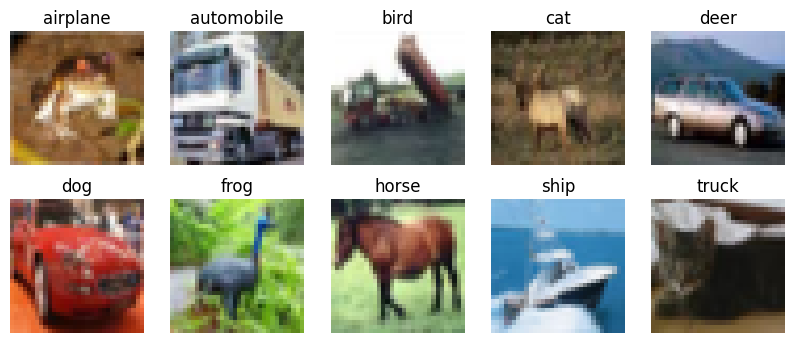

In [308]:
NUM_IMAGES = 10

fig = plt.figure(figsize=(10, 4))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i in range(NUM_IMAGES):
    im = x_train[i, :, :, :]
    ax = fig.add_subplot(2, 5, i + 1)
    ax.imshow(im)
    ax.set_title(LABELS[i])
    ax.axis('off')
plt.show()

### Feature extraction phase with an autoencoder

In [309]:
class Encoder(keras.Model):
    def __init__(self, num_filters=32, latent_dim=128, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = layers.Conv2D(num_filters, kernel_size=3, 
                                   activation="relu", strides=2, padding='same', name='enc_conv1')
        self.conv2 = layers.Conv2D(num_filters * 2, kernel_size=3, 
                                   activation="relu", padding='same', name='enc_conv2')
        self.conv3 = layers.Conv2D(num_filters * 2, kernel_size=3, 
                                   activation="relu", padding='same', strides=2, name='enc_conv3')
        self.conv4 = layers.Conv2D(num_filters * 2, kernel_size=3, 
                                   activation="relu", padding='same', name='enc_conv4')
        self.conv5 = layers.Conv2D(num_filters * 2, kernel_size=3, 
                                   activation="relu", padding='same', strides=2, name='enc_conv5')
        self.flatten = layers.Flatten(name='enc_flatten')
        self.dense = layers.Dense(latent_dim, activation="relu", name='enc_dense')
        
    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.flatten(x)
        x = self.dense(x)
        return x

encoder = Encoder(num_filters=32, latent_dim=128, name='encoder')
encoder.build((1, 32, 32, 3))
encoder.summary()

class Decoder(keras.Model):
    def __init__(self, num_filters=32, output_channels=3, **kwargs):
        super().__init__(**kwargs)
        self.dense = layers.Dense(16 * num_filters, activation="relu", name='dec_dense')
        self.reshape = layers.Reshape((4, 4, num_filters), name='dec_reshape')
        self.upsam1 = layers.UpSampling2D(size=(2, 2), interpolation="bilinear", name='dec_upsampling1')
        self.conv1 = layers.Conv2D(num_filters * 4, kernel_size=3, activation="relu", 
                                   padding='same', name='dec_conv1')
        self.upsam2 = layers.UpSampling2D(size=(2, 2), interpolation="bilinear", name='dec_upsampling2')
        self.conv2 = layers.Conv2D(num_filters * 2, kernel_size=3, activation="relu", 
                                   padding='same', name='dec_conv2')
        self.upsam3 = layers.UpSampling2D(size=(2, 2), interpolation="bilinear", name='dec_upsampling3')
        self.conv3 = layers.Conv2D(output_channels, kernel_size=3, activation="sigmoid", 
                                   padding='same', name='dec_conv3')
    
    def call(self, x):
        x = self.dense(x)
        x = self.reshape(x)
        x = self.upsam1(x)
        x = self.conv1(x)
        x = self.upsam2(x)
        x = self.conv2(x)
        x = self.upsam3(x)
        x = self.conv3(x)
        return x

decoder = Decoder(num_filters=32, output_channels=3, name='decoder')
decoder.build((1, 128))
decoder.summary()

class AutoEncoder(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    
autoencoder = AutoEncoder(encoder, decoder, name='autoencoder') 
optimizer = Adam()
autoencoder.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["mse"])
autoencoder.build((1, 32, 32, 3))
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 enc_conv1 (Conv2D)          multiple                  896       
                                                                 
 enc_conv2 (Conv2D)          multiple                  18496     
                                                                 
 enc_conv3 (Conv2D)          multiple                  36928     
                                                                 
 enc_conv4 (Conv2D)          multiple                  36928     
                                                                 
 enc_conv5 (Conv2D)          multiple                  36928     
                                                                 
 enc_flatten (Flatten)       multiple                  0         
                                                                 
 enc_dense (Dense)           multiple                  1312

Loading of the pre-trained weights to save computational resources and time. Otherwise, it will be trained

In [310]:
filename = 'autoencoder_cifar10_CBIR.h5'

if not os.path.exists(filename):
    autoencoder.fit(x_train, x_train,
            epochs=100,
            batch_size=32,
            validation_data=(x_test, x_test))
    autoencoder.save_weights(filename)
else:
    autoencoder.load_weights(filename)

Test how the autoencoder works with 3 random images

1/1 [==============================] - 0s 108ms/step


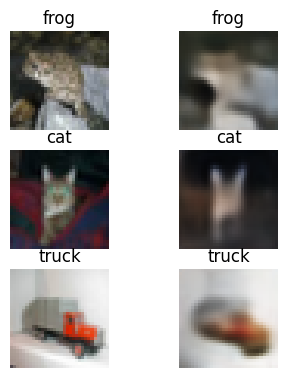

In [311]:
num_images = 3
idx_random = np.random.choice(x_train.shape[0], num_images)

y_hat = autoencoder.predict(x_train[idx_random])

fig = plt.figure(figsize=(4, num_images*3))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i in range(num_images):
    im = x_train[idx_random, :, :, :]
    ax1 = fig.add_subplot(6, 2, i * 2 + 1)
    ax1.imshow(x_train[idx_random[i]])
    ax1.set_title(LABELS[y_train[idx_random[i]][0]])
    ax1.axis('off')
    ax2 = fig.add_subplot(6, 2, i * 2 + 2)
    ax2.imshow(y_hat[i])
    ax2.set_title(LABELS[y_train[idx_random[i]][0]])
    ax2.axis('off')
plt.show()

### Similarity calculation and retrieval

In [312]:
# This is our similarity measure, the euclidean distance between x and y. The closer to 0 the more similar x and y are.
def euclidean_distance(x: np.array, y: np.array) -> float:
    distance = np.sum((x-y)**2)
    return distance

In [313]:
# Implementing the cosine distance based on cosine similarity
def cosine_distance(x:np.array, y:np.array) -> float:
    x = x/np.linalg.norm(x)
    y = y/np.linalg.norm(y)
    distance = 1 - (np.dot(x,y)/(np.sqrt(np.dot(x,x))*np.sqrt(np.dot(y,y))))
    return distance

In [314]:
#IDX_SAMPLE = 10 # This corresponds to the index of the query image (AIRPLANE)
#IDX_SAMPLE = 13 # This corresponds to the index of the query image (HORSE)
IDX_SAMPLE = 23 # This corresponds to the index of the query image (TRUCK)
NUM_SAMPLES = 9 # Number of images to retrieve

In [315]:
def visualize_similar_images(retrieved_idx:np.array, retrieved_distances:np.array) -> None:
    fig = plt.figure(figsize=(16, 4))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    ax = fig.add_subplot(2, 5, 1)

    ax.imshow(x_test[IDX_SAMPLE,:,:,:])
    ax.set_title(f'Test image: {LABELS[y_test[IDX_SAMPLE][0]]}')
    ax.axis('off')
    for i in range(NUM_SAMPLES):
        im = x_train[np.squeeze(retrieved_idx)[i], :, :, :]
        ax = fig.add_subplot(2, 5, i + 2)
        ax.imshow(im)
        ax.set_title(LABELS[y_train[np.squeeze(retrieved_idx)[i]][0]] + " "+ format(retrieved_distances[0][i], ".2e"))
        ax.axis('off')
    plt.show()

### Using histogram as features

In [316]:
def extract_features_hist(images:np.array) -> np.array:
    feats = []
    for im in images:
        height, width, _ = im.shape
        for i in range(3):  # Vertical regions
            for j in range(3):  # Horizontal regions
                # Calculate region boundaries
                x1 = int(j * width / 3)
                x2 = int((j + 1) * width / 3)
                y1 = int(i * height / 3)
                y2 = int((i + 1) * height / 3)
                # Extract region and calculate histogram
                region = im[y1:y2, x1:x2]
                for k in range(3):  # Channels
                    hist = cv2.calcHist([region], [k], None, [256], [0,1])
                    cv2.normalize(hist, hist)
                    feats.append(hist.flatten())
    feats = np.reshape(feats, (len(images), 256*3*9))
    return feats

Show the results with histogram using the euclidean distance

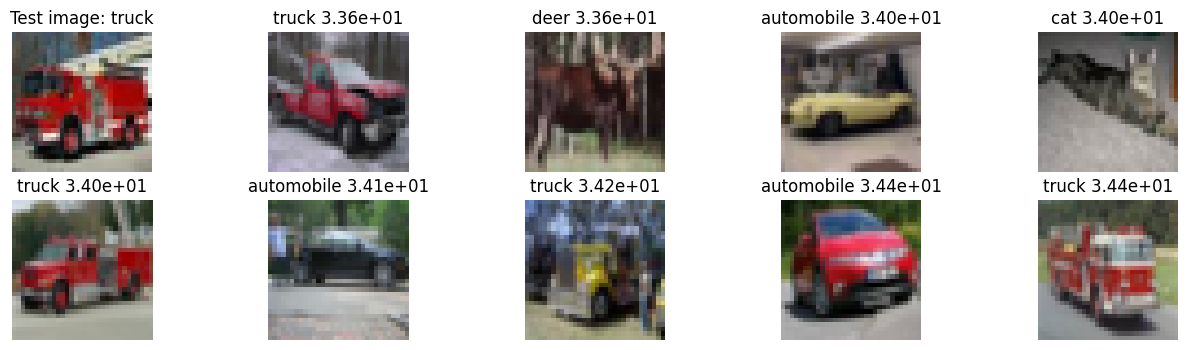

In [317]:
train_feats_hist = extract_features_hist(x_train) # Train set
test_feats_hist = extract_features_hist(x_test) # Test set

knn = KNeighborsClassifier(n_neighbors=1, metric=euclidean_distance).fit(train_feats_hist, y_train.ravel())

query_feats_hist = test_feats_hist[IDX_SAMPLE].reshape(1, -1)

# This function retrieve the indexes and distances of the n neighbors most similar to the query image
retrieved_distances, retrieved_idx = knn.kneighbors(query_feats_hist, n_neighbors=NUM_SAMPLES, return_distance=True)

visualize_similar_images(retrieved_idx, retrieved_distances)

Show the results with histogram using the cosine distance

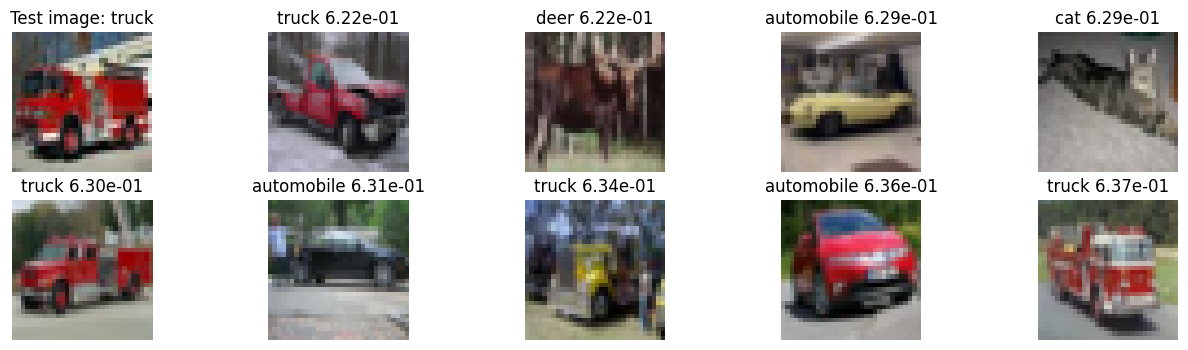

In [318]:
train_feats_hist = extract_features_hist(x_train) # Train set
test_feats_hist = extract_features_hist(x_test) # Test set

knn = KNeighborsClassifier(n_neighbors=1, metric=cosine_distance).fit(train_feats_hist, y_train.ravel())

query_feats_hist = test_feats_hist[IDX_SAMPLE].reshape(1, -1)    

# This function retrieve the indexes and distances of the n neighbors most similar to the query image
retrieved_distances, retrieved_idx = knn.kneighbors(query_feats_hist, n_neighbors=NUM_SAMPLES, return_distance=True)

visualize_similar_images(retrieved_idx, retrieved_distances)

### Using CNN as features

In [319]:
# Here we use the encoder to return the latent features of the input images
def extract_features(images:np.array) -> np.array:
    feats = encoder.predict(images)
    return feats

Show the results with CNN using the euclidean distance

313/313 [==============================] - 2s 8ms/step


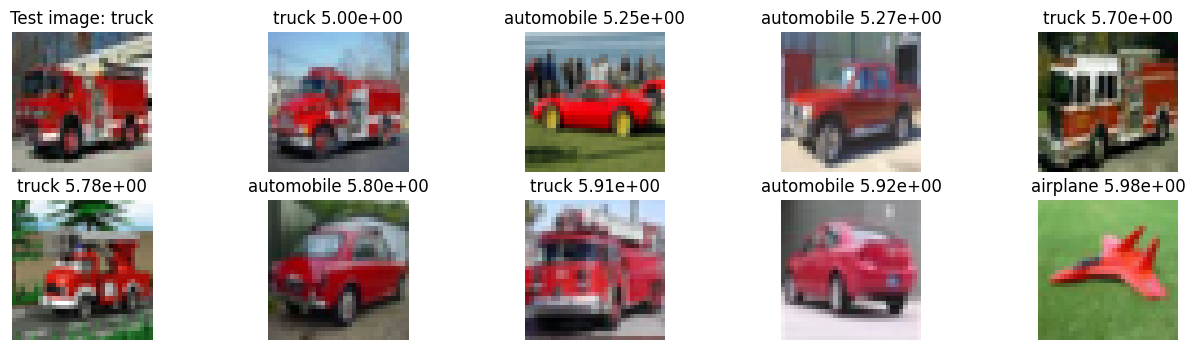

In [320]:
train_feats = extract_features(x_train) # Train set
test_feats = extract_features(x_test) # Test set

knn = KNeighborsClassifier(n_neighbors=1, metric=euclidean_distance).fit(train_feats, y_train.ravel())

query_feats = test_feats[IDX_SAMPLE].reshape(1, -1)    

# This function retrieve the indexes and distances of the n neighbors most similar to the query image
retrieved_distances, retrieved_idx = knn.kneighbors(query_feats, n_neighbors=NUM_SAMPLES, return_distance=True)

visualize_similar_images(retrieved_idx, retrieved_distances)

Show the results with CNN using the cosine distance

313/313 [==============================] - 2s 7ms/step


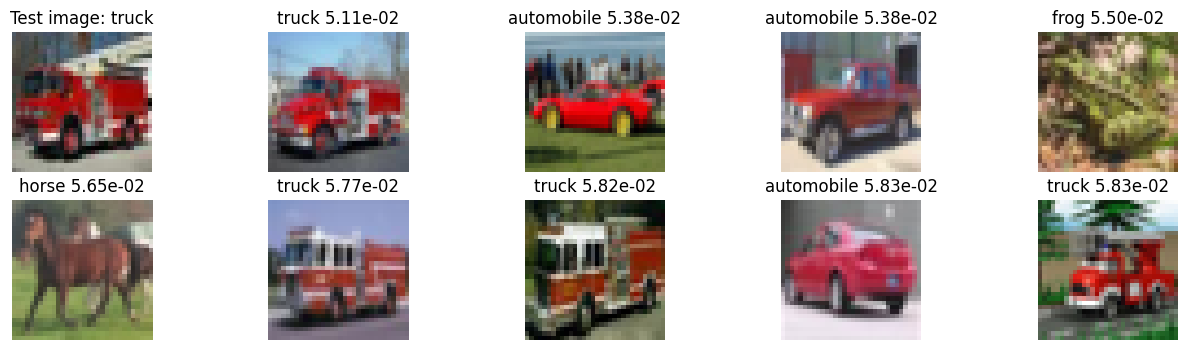

In [321]:
train_feats = extract_features(x_train) # Train set
test_feats = extract_features(x_test) # Test set

knn = KNeighborsClassifier(n_neighbors=1, metric=cosine_distance).fit(train_feats, y_train.ravel())

query_feats = test_feats[IDX_SAMPLE].reshape(1, -1)

# This function retrieve the indexes and distances of the n neighbors most similar to the query image
retrieved_distances, retrieved_idx = knn.kneighbors(query_feats, n_neighbors=NUM_SAMPLES, return_distance=True)

visualize_similar_images(retrieved_idx, retrieved_distances)

### Using histogram + CNNs as features

In [322]:
# Here we use the encoder to return the latent features of the input images
def extract_features_autoencoder(images:np.array) -> np.array:
    feats = autoencoder.predict(images)
    return feats

In [323]:
def extract_features_hist_cnn(images: np.array) -> np.array:
    cnn_feats = extract_features_autoencoder(images)
    hist_feats = extract_features_hist(cnn_feats)  
    return hist_feats

Show the results with histogram+CNNs using the euclidean distance

313/313 [==============================] - 7s 23ms/step


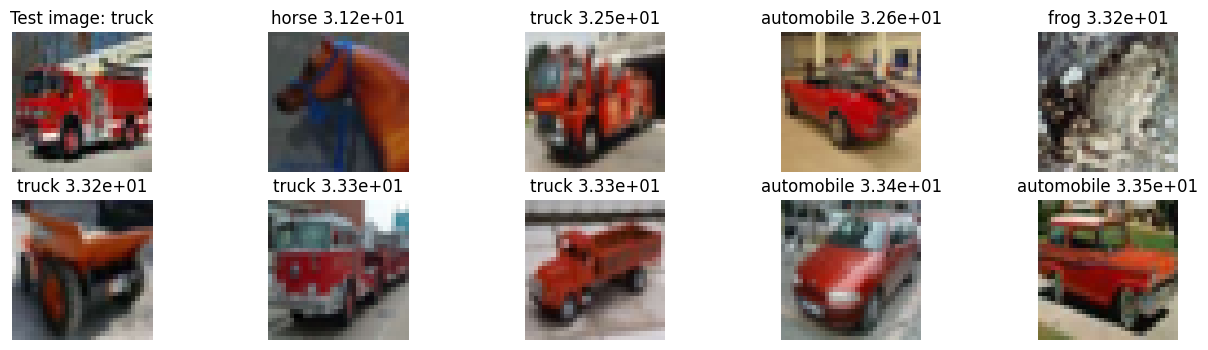

In [324]:
train_feats_hist_cnn = extract_features_hist_cnn(x_train) # Train set
test_feats_hist_cnn = extract_features_hist_cnn(x_test) # Test set

knn = KNeighborsClassifier(n_neighbors=1, metric=euclidean_distance).fit(train_feats_hist_cnn, y_train.ravel())

query_feats_hist_cnn = test_feats_hist_cnn[IDX_SAMPLE].reshape(1, -1)

# This function retrieve the indexes and distances of the n neighbors most similar to the query image
retrieved_distances, retrieved_idx = knn.kneighbors(query_feats_hist_cnn, n_neighbors=NUM_SAMPLES, return_distance=True)

visualize_similar_images(retrieved_idx, retrieved_distances)

Show the results with histogram+CNNs using the cosine distance

313/313 [==============================] - 7s 23ms/step


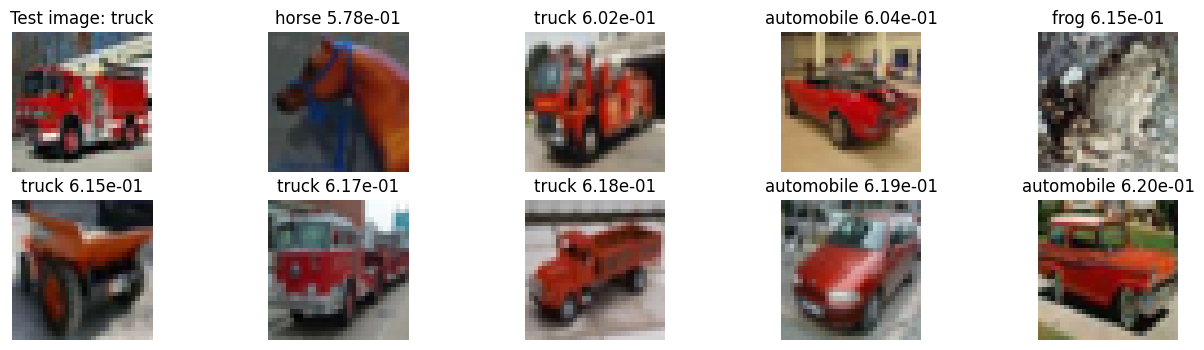

In [325]:
train_feats_hist_cnn = extract_features_hist_cnn(x_train) # Train set
test_feats_hist_cnn = extract_features_hist_cnn(x_test) # Test set

knn = KNeighborsClassifier(n_neighbors=1, metric=cosine_distance).fit(train_feats_hist_cnn, y_train.ravel())

query_feats_hist_cnn = test_feats_hist_cnn[IDX_SAMPLE].reshape(1, -1)

# This function retrieve the indexes and distances of the n neighbors most similar to the query image
retrieved_distances, retrieved_idx = knn.kneighbors(query_feats_hist_cnn, n_neighbors=NUM_SAMPLES, return_distance=True)

visualize_similar_images(retrieved_idx, retrieved_distances)